In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import tensorly.random as tl_rand
import tensorly.kruskal_tensor as tl_kruskal
import numpy as np
import statistics
from timeit import default_timer as timer
 
from BLOCK_SPG_CPD import bras_CPD
from BLOCK_SPG_CPD import ada_CPD

Using numpy backend.


In [2]:
# Set up
rank = 100
F = tl_rand.random_kruskal((300,300,300), rank, full=False)
X = tl_kruskal.kruskal_to_tensor(F)
B = 20
b = 10**-6
eps = 0
eta = 1
alpha = 0.1
beta = 10**-6

In [43]:
from helper import rand_init
from helper import norm
from helper import unfold

norm_x_time = []
norm_f_time = []
rand_time = []
col_time = []
unfold_time = []

for i in range(100):
    rank = 100
    F = tl_rand.random_kruskal((300,300,300), rank, full=False)
    X = tl_kruskal.kruskal_to_tensor(F)

    start = timer()
    norm_x = norm(X)
    end = timer()
    norm_x_time.append(end-start)

    start = timer()
    F_norm = [norm(F[0]), norm(F[1]), norm(F[2])]
    end = timer()
    norm_f_time.append(end-start)

    start = timer()
    dim_1, dim_2, dim_3 = X.shape
    A = [rand_init(dim_1, rank), rand_init(dim_2, rank), rand_init(dim_3, rank)]
    end = timer()
    rand_time.append(end-start)

    start = timer()
    total_col = {0:dim_2*dim_3, 1:dim_1*dim_3, 2:dim_1*dim_2}
    end = timer()
    col_time.append(end-start)
    
    start = timer()
    X_unfold = [unfold(X, mode=0), unfold(X, mode=1), unfold(X, mode=2)]
    end = timer()
    unfold_time.append(end-start)
    

mean_x = statistics.mean(norm_x_time)
var_x = statistics.variance(norm_x_time)

mean_f = statistics.mean(norm_f_time)
var_f = statistics.variance(norm_f_time)

mean_rand = statistics.mean(rand_time)
var_rand = statistics.variance(rand_time)

mean_col = statistics.mean(col_time)
var_col = statistics.variance(col_time)

mean_unfold = statistics.mean(unfold_time)
var_unfold = statistics.variance(unfold_time)

[0.015208744999972624, 0.0001594999999997526, 0.0014233750000039436, 3.823999932137667e-06, 0.2564313400000174]
0.27322678399992584


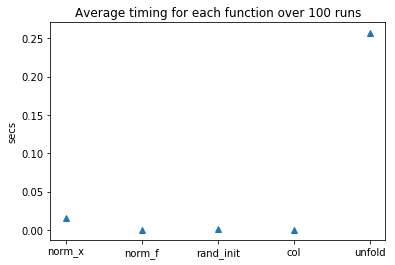

In [40]:
x = ['norm_x', 'norm_f', 'rand_init', 'col', 'unfold']
y = [mean_x, mean_f, mean_rand, mean_col, mean_unfold]
var = [var_x, var_f, var_rand, var_col, var_unfold]
plt.ylabel('secs')
plt.title('Average timing for each function over 100 runs')
plt.errorbar(x,y, var,linestyle='None', marker='^')

print(y)
print(sum(y))

In [41]:
print(X_unfold[0].shape)
print(X_unfold[1].shape)
print(X_unfold[2].shape)

(90000, 300)
(90000, 300)
(90000, 300)


In [45]:
from helper import rand_init
from helper import norm
from helper import sample
from helper import generate_sketch_indices
from helper import update_factor_bras

sample_time = []
sketch_time = []
update_time = []
alpha_time = []

for r in range(100):
    rank = 100
    F = tl_rand.random_kruskal((300,300,300), rank, full=False)
    X = tl_kruskal.kruskal_to_tensor(F)
    X_unfold = [unfold(X, mode=0), unfold(X, mode=1), unfold(X, mode=2)]
    
    start = timer()
    n = sample(3)
    end = timer()
    sample_time.append(end-start)

    start = timer()
    idx = generate_sketch_indices(B, total_col[n])
    end = timer()
    sketch_time.append(end-start)

    start = timer()
    update_factor_bras(X_unfold, A, idx, n, rank, alpha)
    end = timer()
    update_time.append(end-start)

    start = timer()
    alpha /= (r+1)**beta
    end = timer()
    alpha_time.append(end-start)

mean_sample = statistics.mean(sample_time)
var_sample = statistics.variance(sample_time)

mean_sketch = statistics.mean(sketch_time)
var_sketch = statistics.variance(sketch_time)

mean_update = statistics.mean(update_time)
var_update = statistics.variance(update_time)

mean_alpha = statistics.mean(alpha_time)
var_alpha = statistics.variance(alpha_time)
    

[2.624400000058813e-05, 0.0035991199999807575, 0.07993915900001411, 6.571999938387307e-06]
0.08357109499993384


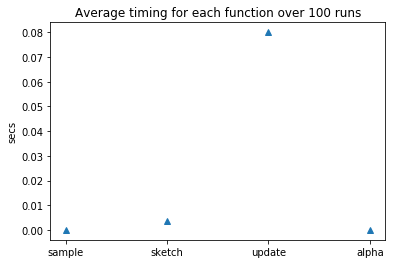

In [51]:
x = ['sample', 'sketch', 'update', 'alpha']
y = [mean_sample, mean_sketch, mean_update, mean_alpha]
var = [var_sample, var_sketch, var_update, var_alpha]
plt.ylabel('secs')
plt.title('Average timing for each function over 100 runs')
plt.errorbar(x,y, var,linestyle='None', marker='^')

print(y)
print(sum(y))

In [10]:
import tensorly.tenalg as tl_alg
from helper import rand_init
from helper import unfold
from helper import sample
from helper import generate_sketch_indices

khatri_time = []
grad_time = []
update_time = []
clip_time = []
    

for i in range(100):   
    rank = 100
    F = tl_rand.random_kruskal((300,300,300), rank, full=False)
    X = tl_kruskal.kruskal_to_tensor(F)
    dim_1, dim_2, dim_3 = X.shape
    A = [rand_init(dim_1, rank), rand_init(dim_2, rank), rand_init(dim_3, rank)]
    X_unfold = [unfold(X, mode=0), unfold(X, mode=1), unfold(X, mode=2)]
    total_col = {0:dim_2*dim_3, 1:dim_1*dim_3, 2:dim_1*dim_2}
    n = sample(3)
    alpha = 0.1
    idx = generate_sketch_indices(B, total_col[n])


    start = timer()
    H_n = (tl_alg.khatri_rao(A, skip_matrix=n))[idx, :]
    end = timer()
    khatri_time.append(end-start)

    start = timer()
    grad = 1/rank * (A[n] @ H_n.T @ H_n - X_unfold[n][:, idx] @ H_n)
    end = timer()
    grad_time.append(end-start)

    start = timer()
    A[n] -= alpha * grad
    end = timer()
    update_time.append(end-start)

    # Apply proximal regularization constraint (A > 0)
    start = timer()
    A[n] = np.clip(A[n], a_min=0, a_max=None)
    end = timer()
    clip_time.append(end-start)
    
mean_khatri = statistics.mean(khatri_time)
var_khatri = statistics.variance(khatri_time)

mean_grad = statistics.mean(grad_time)
var_grad = statistics.variance(grad_time)

mean_update = statistics.mean(update_time)
var_update = statistics.variance(update_time)

mean_clip = statistics.mean(clip_time)
var_clip = statistics.variance(clip_time)


[0.1606172489999983, 0.005633281999993187, 0.00016770399999131767, 7.723599999167164e-05]
0.1664954709999745


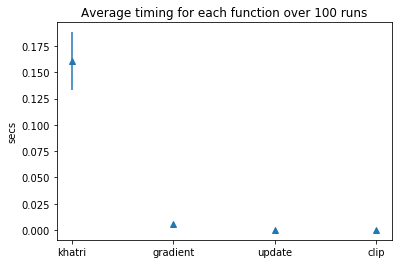

In [11]:
x = ['khatri', 'gradient', 'update', 'clip']
y = [mean_khatri, mean_grad, mean_update , mean_clip]
var = [var_khatri, var_grad, var_update , var_clip]
plt.ylabel('secs')
plt.title('Average timing for each function over 100 runs')
plt.errorbar(x,y, var,linestyle='None', marker='^')

print(y)
print(sum(y))